In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
import sklearn.neighbors as skl

In [2]:
spikes = np.genfromtxt('MDA3_data/spikes.txt')

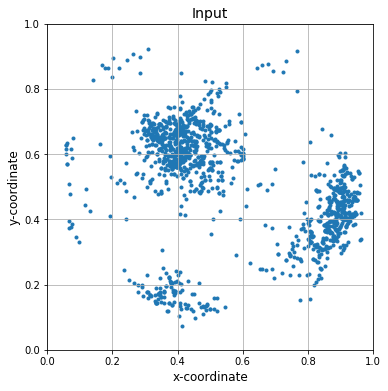

In [287]:
plt.figure(figsize = (6,6))
plt.scatter(spikes[:,0],spikes[:,1], marker ='.')
plt.title('Input', fontsize = 14)
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#### Histogram

In [4]:
x_edges = np.linspace(0,1,100)
y_edges = np.linspace(0,1,100)
Pxy, _,_ = np.histogram2d(spikes[:,0],spikes[:,1], bins = (x_edges, y_edges))
Pxy_norm = Pxy/sum(sum(Pxy))

Text(0, 0.5, 'y-coordinate')

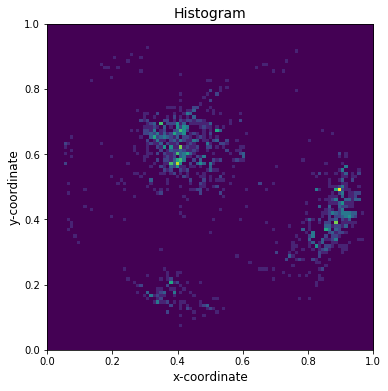

In [303]:
plt.figure(figsize = (6,6))
plt.imshow(Pxy_norm.T, extent=[0,1,0,1], origin = 'lower')
plt.title('Histogram', fontsize = 14)
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)

### Kernel: gaussian

In [278]:
def gaussian(z, C):
    return np.exp(-np.dot(np.dot(np.transpose(z),np.linalg.inv(C)),z)/2)/(2*np.pi*np.linalg.det(C)**(0.5))

In [279]:
def kernel(sample, grid, C):
    n = len(sample)
    P = np.zeros(len(grid))
    for i in range(len(grid)):
        for j in range(n):
            P[i] += gaussian(grid[i]-sample[j],C)/n 
    return P

In [280]:
pregrid = np.meshgrid(x_edges,y_edges)
grid = np.dstack((pregrid[0].flatten(), pregrid[1].flatten()))[0]
C = [[0.001, 0],[0, 0.001]]
P_gaus = kernel(spikes, grid = grid, C = C)

Text(0, 0.5, 'y-coordinate')

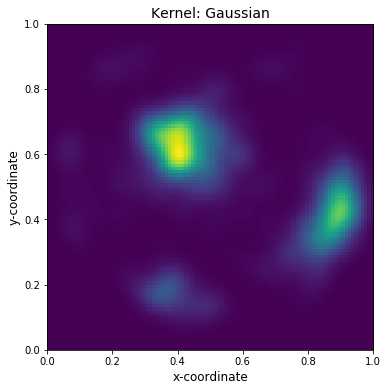

In [301]:
plt.figure(figsize = (6,6))
plt.imshow(np.reshape(P_gaus, (100,100)), extent=[0,1,0,1], origin = 'lower')
plt.title('Kernel: Gaussian', fontsize = 14)
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)

### Kernel Epanechnikov

In [230]:
# def epa(z, C):
#     h = np.sqrt(np.linalg.det(C))
# #     if np.abs(np.dot(np.transpose(z),z)) < 1:
# #     k = 2*(1 - np.dot(np.dot(np.transpose(z),np.linalg.inv(C)),z))/(np.linalg.det(C)**(0.5)*np.pi)
#     k = 2*(1 - np.dot(np.transpose(z),z)/h**2)
# #     else: k = 0
#     return k

In [231]:
# def epa_kernel(sample, grid, C):
#     n = len(sample)
#     P = np.zeros(len(grid))
#     for i in range(len(grid)):
#         for j in range(n):
#             P[i] += epa(grid[i]-sample[j],C)/n 
#     P = P/sum(P)
#     return P

In [238]:
# pregrid = np.meshgrid(x_edges,y_edges)
# grid = np.dstack((pregrid[0].flatten(), pregrid[1].flatten()))[0]
# s = 100
# C = [[s, 0],[0, s]]
# P_epa = epa_kernel(spikes, grid = grid, C = C)

In [266]:
# plt.figure(figsize = (6,6))
# plt.imshow(np.reshape(P_epa, (100,100)), extent=[0,1,0,1])
# plt.xlabel('x-coordinate', fontsize = 12)
# plt.ylabel('y-coordinate', fontsize = 12)

In [330]:
def kde2D(x, y, bandwidth, kern, xx, yy): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    #xx, yy = np.mgrid[0:1:101j,0:1:101j]

    xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T
    xy_train  = np.vstack([x, y]).T

    kde_skl = skl.KernelDensity(kernel = kern, bandwidth=bandwidth)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx,yy,z,kde_skl

In [268]:
kernels = ['gaussian', 'epanechnikov', 'exponential']
# kernels = ['epanechnikov']
model=[]
for k in kernels:
    model.append(kde2D(spikes[:,0],spikes[:,1],np.sqrt(0.001),k))

Text(0, 0.5, 'y-coordinate')

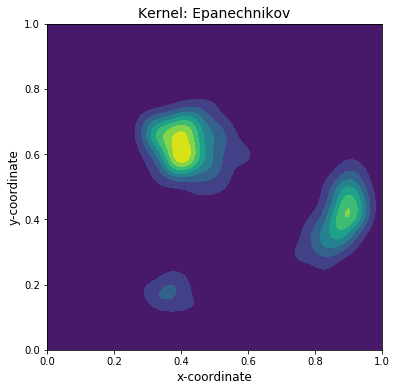

In [274]:
plt.figure(figsize = (6,6))
plt.contourf(model[1][0],model[1][1],np.reshape(model[0][2],model[2][0].shape))
plt.title('Kernel: Epanechnikov', fontsize = 14)
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)

### Kernel exponential

In [305]:
def exponential(z, C):
    l = np.sqrt(np.linalg.det(C))
    return l*np.exp(-np.sqrt(np.dot(np.transpose(z),z))/l)/(2*np.pi)

In [306]:
def exp_kernel(sample, grid, C):
    n = len(sample)
    P = np.zeros(len(grid))
    for i in range(len(grid)):
        for j in range(n):
            P[i] += exponential(grid[i]-sample[j],C)/n 
    P = P/sum(P)
    return P

In [207]:
C = [[0.001, 0],[0, 0.001]]
P_exp = exp_kernel(spikes, grid = grid, C = C)

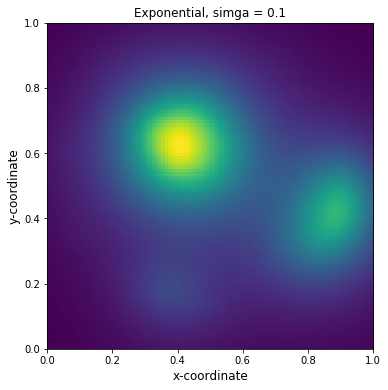

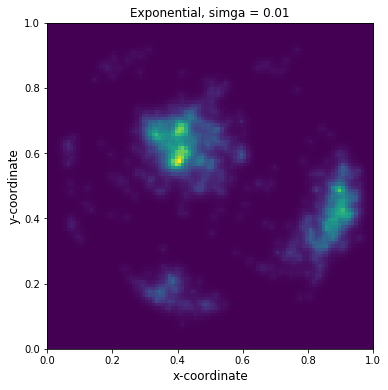

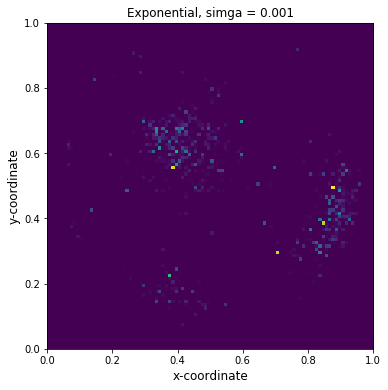

In [307]:
pregrid = np.meshgrid(x_edges,y_edges)
grid = np.dstack((pregrid[0].flatten(), pregrid[1].flatten()))[0]
sig = [0.1,0.01,0.001]
P_exp_all = np.empty((len(sig), len(grid)))
for i,s in enumerate(sig):
    C = [[s, 0],[0, s]]
    P_exp_all[i] = exp_kernel(spikes, grid = grid, C = C)
    plt.figure(figsize = (6,6))
    plt.title('Exponential, simga = {}'.format(s))
    plt.imshow(np.reshape(P_exp_all[i], (100,100)), extent=[0,1,0,1], origin = 'lower')
    plt.xlabel('x-coordinate', fontsize = 12)
    plt.ylabel('y-coordinate', fontsize = 12)

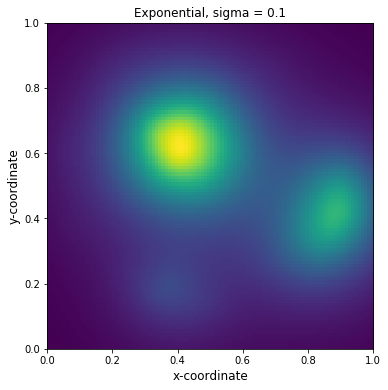

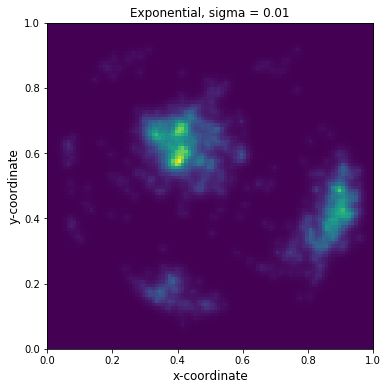

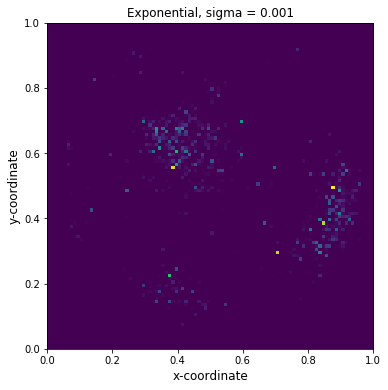

In [309]:
for i,s in enumerate(sig):
    plt.figure(figsize = (6,6))
    plt.title('Exponential, sigma = {}'.format(s))
    plt.imshow(np.reshape(P_exp_all[i], (100,100)), extent=[0,1,0,1], origin = 'lower')
    plt.xlabel('x-coordinate', fontsize = 12)
    plt.ylabel('y-coordinate', fontsize = 12)

### Likelihood

In [325]:
test_sorted = np.sort(test, axis = 0)

In [327]:
Ph, _,_ = np.histogram2d(spikes[:,0],spikes[:,1], bins = (test_sorted[:,0], test_sorted[:,1]))

Text(0, 0.5, 'y-coordinate')

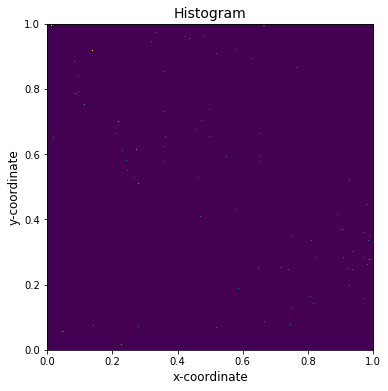

In [345]:
plt.figure(figsize = (6,6))
plt.imshow(Phist.T, extent=[0,1,0,1], origin = 'lower')
plt.title('Histogram', fontsize = 14)
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)

In [329]:
C = [[0.001, 0],[0, 0.001]]
P_gaus_test = kernel(spikes, grid = test_sorted, C = C)

In [331]:
kernels = ['gaussian', 'epanechnikov', 'exponential']
# kernels = ['epanechnikov']
model_test=[]
for k in kernels:
    model_test.append(kde2D(spikes[:,0],spikes[:,1],np.sqrt(0.001),k, test_sorted[:,0], test_sorted[:,1]))

In [337]:
model_test[1][2].shape

(1310,)

In [347]:
s = 0.01
C = [[s, 0],[0, s]]
P_exp_test = exp_kernel(spikes, grid = test_sorted, C = C)

In [348]:
L_hist = sum(np.log(Phist))
L_gaus = sum(np.log(P_gaus_test))
L_epa = sum(np.log(model_test[1][2]))
L_exp = sum(np.log(P_exp_test))
print(L_hist, L_gaus, L_epa, L_exp)

[-inf -inf -inf ... -inf -inf -inf] -1714.442521755959 -inf -12337.583014927612


/Users/ekaterinamaksimova/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/ekaterinamaksimova/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


### Testing

In [109]:
test = np.genfromtxt('MDA3_data/spikes_test.txt')

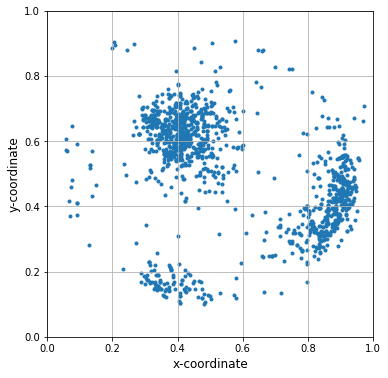

In [112]:
plt.figure(figsize = (6,6))
plt.scatter(test[:,0],test[:,1], marker ='.')
plt.xlabel('x-coordinate', fontsize = 12)
plt.ylabel('y-coordinate', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [133]:
C = [[0.001, 0],[0, 0.001]]
P_test_gaus = kernel(spikes, grid = test, C = C)

In [134]:
P_test_gaus

array([ 0.06668384,  9.39207963, 15.76197262, ..., 14.10431454,
        0.30953737,  3.32168647])

In [135]:
L_test_gaus = sum(np.log(P_test_gaus))
print(L_test_gaus)

2091.8895993774704


### Selection of sigma

In [143]:
sigma = np.arange(0.0001, 0.0031, 0.0001)

In [145]:
L_s = np.empty(len(sigma))
for i,s in enumerate(sigma):
    curr_c = [[s, 0],[0, s]]
    P_s = np.empty(len(grid))
    print(s)
    P_s = kernel(spikes, grid = test, C = curr_c)
    L_s[i] = sum(np.log(P_s))

0.0001
0.0002
0.00030000000000000003
0.0004
0.0005
0.0006000000000000001
0.0007000000000000001
0.0008
0.0009000000000000001
0.001
0.0011
0.0012000000000000001
0.0013000000000000002
0.0014000000000000002
0.0015
0.0016
0.0017000000000000001
0.0018000000000000002
0.0019000000000000002
0.002
0.0021
0.0022
0.0023
0.0024
0.0025
0.0026
0.0027
0.0028
0.0029
0.003


In [146]:
L_s

array([1790.3612935 , 2050.84737829, 2110.41993152, 2128.12534512,
       2131.10218437, 2127.50262268, 2120.58430741, 2111.87473253,
       2102.16406944, 2091.88959938, 2081.30572484, 2070.56620866,
       2059.76668817, 2048.96785335, 2038.20866382, 2027.51418722,
       2016.9004116 , 2006.37729052, 1995.95072007, 1985.62384972,
       1975.39796639, 1965.27309849, 1955.24843273, 1945.32260395,
       1935.49389753, 1925.76039103, 1916.12005326, 1906.5708132 ,
       1897.1106074 , 1887.73741192])

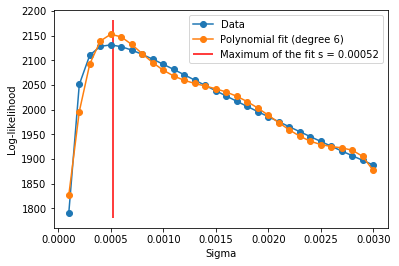

In [353]:
deg = 6
curve = np.poly1d(np.polyfit(sigma, L_s, deg))
plt.figure()
plt.plot(sigma, L_s, marker = 'o', label = 'Data')
plt.plot(sigma, curve(sigma), marker = 'o', label = 'Polynomial fit (degree {})'.format(deg))
y = np.linspace(0.0001, 0.0031, 100)
opt_s = y[np.argmax(curve(y))]
plt.vlines(opt_s, min(L_s)-10, max(L_s)+50, color = 'r', label = 'Maximum of the fit s = {:.5f}'.format(opt_s))
plt.xlabel('Sigma')
plt.ylabel('Log-likelihood')
plt.legend()

No handles with labels found to put in legend.


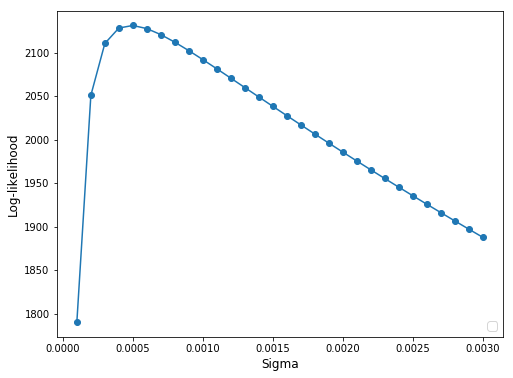

In [288]:
plt.figure(figsize = (8,6))
plt.plot(sigma, L_s,marker = 'o')
plt.ylabel('Log-likelihood', fontsize = 12 )
plt.xlabel('Sigma', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)